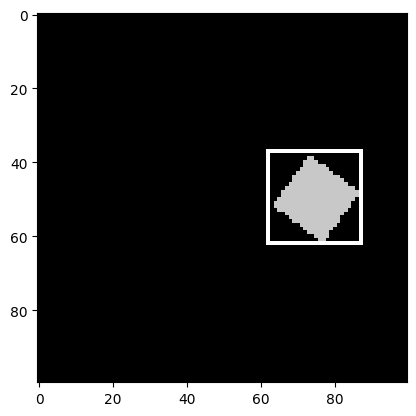

In [1]:
from torch import nn
import torch
import torchvision
import matplotlib.pyplot as plt
import square_data_generator
from torchvision.utils import draw_bounding_boxes

N_SQUARES = 1
IMAGE_SIZE = (100, 100)

test_img, test_bboxes, test_colors = square_data_generator.make_image(
    IMAGE_SIZE, N_SQUARES
)
pred_points = torchvision.ops.box_convert(test_bboxes, in_fmt="cxcywh", out_fmt="xyxy")

img_with_boxes = draw_bounding_boxes(
    (test_img.permute(2, 0, 1) * 255).to(torch.uint8),
    pred_points,
    colors=test_colors,
    width=1,
)
plt.imshow(img_with_boxes.permute(1, 2, 0));

In [2]:
test_img.shape

torch.Size([100, 100, 3])

In [3]:
from square_data_generator import label_sort_order_big_to_small


def ordered_loss_big_to_small(
    predicted_bboxes: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    _loss = 0

    for batch_idx in range(predicted_bboxes.size(0)):
        # sort_idx = label_sort_order_big_to_small(predicted_bboxes[batch_idx])
        for idx in range(N_SQUARES):
            _loss += nn.functional.mse_loss(
                predicted_bboxes[0, idx], target_bboxes[batch_idx][idx]
            )
    return _loss


def point_matching_loss_greedy(
    pred_points: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    target_points = target_bboxes[:, :, :2]

    batch_size = pred_points.size(0)

    # greedy matching step
    removed = torch.zeros(N_SQUARES, dtype=torch.bool)

    loss = 0
    for batch_idx in range(batch_size):
        for idx in torch.randperm(N_SQUARES):  # random shuffle predicted bboxes]:
            # find the target bbox with the smallest L2 distance
            diff = target_points[batch_idx] - pred_points[batch_idx, idx]
            dists = torch.norm(diff, dim=1, p=2)
            dists[removed] = float("inf")  # set removed ones' distance to inf

            best_match_idx = torch.argmin(dists)
            removed[best_match_idx] = True

            loss += nn.functional.mse_loss(
                pred_points[batch_idx, idx], target_points[batch_idx, best_match_idx]
            )

    return loss


def calculate_iou_cxcywh(
    pred_boxes: torch.Tensor, target_boxes: torch.Tensor
) -> torch.Tensor:
    """
    Calculate IoU for bounding boxes in cxcywh format
    Boxes are expected in format [center_x, center_y, width, height]
    """
    # Convert cxcywh to corner coordinates
    pred_cx, pred_cy, pred_w, pred_h = pred_boxes.unbind(-1)
    targ_cx, targ_cy, targ_w, targ_h = target_boxes.unbind(-1)

    # Calculate corner coordinates
    pred_x1 = pred_cx - pred_w / 2
    pred_y1 = pred_cy - pred_h / 2
    pred_x2 = pred_cx + pred_w / 2
    pred_y2 = pred_cy + pred_h / 2

    targ_x1 = targ_cx - targ_w / 2
    targ_y1 = targ_cy - targ_h / 2
    targ_x2 = targ_cx + targ_w / 2
    targ_y2 = targ_cy + targ_h / 2

    # Calculate intersection coordinates
    inter_x1 = torch.max(pred_x1, targ_x1)
    inter_y1 = torch.max(pred_y1, targ_y1)
    inter_x2 = torch.min(pred_x2, targ_x2)
    inter_y2 = torch.min(pred_y2, targ_y2)

    # Calculate intersection area
    inter_width = torch.clamp(inter_x2 - inter_x1, min=0)
    inter_height = torch.clamp(inter_y2 - inter_y1, min=0)
    inter_area = inter_width * inter_height

    # Calculate union area
    pred_area = pred_w * pred_h
    targ_area = targ_w * targ_h
    union_area = pred_area + targ_area - inter_area

    # Calculate IoU
    iou = inter_area / (union_area + 1e-6)  # Add epsilon to avoid division by zero
    return iou


def ordered_iou_loss_big_to_small(
    predicted_bboxes: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    """
    Calculate IoU loss for ordered bounding boxes in cxcywh format
    Args:
        predicted_bboxes: Tensor of shape (batch_size, num_boxes, 4) in [cx, cy, w, h]
        target_bboxes: Tensor of shape (batch_size, num_boxes, 4) in [cx, cy, w, h]
    Returns:
        Total IoU loss
    """
    _loss = 0.0

    for batch_idx in range(predicted_bboxes.size(0)):
        for idx in range(5):  # Assuming 5 boxes as in original code
            # Calculate IoU for each pair of boxes
            iou = calculate_iou_cxcywh(
                predicted_bboxes[batch_idx, idx], target_bboxes[batch_idx, idx]
            )
            # Convert IoU to loss (1 - IoU)
            box_loss = 1 - iou
            _loss += box_loss

    return _loss


In [4]:
dataset = square_data_generator.SquareDataset(
    image_size=(100, 100),
    num_boxes=N_SQUARES,
    num_samples=10,
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
import torch
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment


def point_matching_loss_optimal(
    pred_points: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    """
    Compute the matching loss between pred_points and target_bboxes using
    a global optimal assignment (Hungarian algorithm) for each batch element.

    Args:
        pred_points: shape (batch_size, N, 2)
        target_bboxes: shape (batch_size, N, 4) or (batch_size, N, 2 + anything).
                       We only use the first two columns as (x, y).
    Returns:
        total_loss: scalar tensor (sum of MSE across all matched pairs in the entire batch).
    """
    # Only keep the (x, y) part of the target
    target_points = target_bboxes[..., :2]

    # Randomly shuffle predicted bboxes across the batch dim
    # ( If you intended to shuffle per-batch differently, you'd do it per index;
    #   but here it follows your original code's single permutation. )
    batch_perm = torch.randperm(pred_points.size(0))
    pred_points = pred_points[batch_perm]

    batch_size, n_squares, _ = pred_points.shape
    total_loss = 0.0

    for b_idx in range(batch_size):
        # Compute cost matrix of shape (n_squares, n_squares) = squared distances
        # We can use torch.cdist(..., p=2) then square it, or directly compute squared distances
        # cost[i, j] = ||pred_i - target_j||^2
        diff = pred_points[b_idx].unsqueeze(1) - target_points[b_idx].unsqueeze(0)
        # cost_matrix = (diff**2).sum(dim=-1)  # shape: [N, N]
        cost_matrix = (diff.abs()).sum(dim=-1)  # shape: [N, N]

        # Hungarian algorithm: find minimal-cost assignment
        # linear_sum_assignment expects a NumPy array on CPU
        row_ind, col_ind = linear_sum_assignment(cost_matrix.cpu().detach().numpy())

        # Matched pairs: pred_points[b_idx, row_ind] and target_points[b_idx, col_ind]
        matched_pred = pred_points[b_idx, row_ind]
        matched_tgt = target_points[b_idx, col_ind]

        # ----
        # Replicate what your original loop-based code does with
        # nn.functional.mse_loss(...). By default, F.mse_loss uses "mean" over features,
        # and you were summing over squares. So let's replicate that carefully.
        #
        # For each pair, your original code does:
        #     loss += mse_loss(pred[i], target[i])  # which is mean((x1 - x2)^2 + (y1 - y2)^2)
        # Then you sum that across all squares. So effectively you get
        # sum_{i=1..N} ( (dx_i^2 + dy_i^2)/2 ).
        #
        # We can do the same in a vectorized way:

        # mse_per_pair shape [N, 2] -> we mean over dim=1 (the 2D coords), giving shape [N]
        mse_per_pair = F.mse_loss(matched_pred, matched_tgt, reduction="none").mean(
            dim=1
        )

        # Sum across all matched pairs
        total_loss += mse_per_pair.sum()

    return total_loss


In [6]:
import utils
import tqdm
import pred_model
# Training parameters

num_epochs = 40
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = pred_model.PointPredictor(n_output_boxes=N_SQUARES)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_images = []

# Training loop
losses = []
for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
        test_pred_points = model(test_img.permute(2, 0, 1).unsqueeze(0))
        test_images.append(
            utils.draw_points_on_image(test_img.numpy(), test_pred_points[0])
        )

    model.train()
    running_loss = 0.0
    for images, target_bboxes in tqdm.tqdm(dataloader):
        #### override data to be the test image
        # images = test_img.permute(2, 0, 1).unsqueeze(0)
        # target_bboxes = test_bboxes.unsqueeze(0)
        ###
        optimizer.zero_grad()
        pred_points = model(images)
        loss = point_matching_loss_greedy(pred_points, target_bboxes)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # optimizer.step()_loss += loss.item()
        losses.append(loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")
    # losses.append(running_loss / len(dataloader))


100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


Epoch [1/40], Loss: 22190.884765625


100%|██████████| 1/1 [00:00<00:00, 31.57it/s]


Epoch [2/40], Loss: 19604.236328125


100%|██████████| 1/1 [00:00<00:00, 44.38it/s]


Epoch [3/40], Loss: 16332.7060546875


100%|██████████| 1/1 [00:00<00:00, 43.07it/s]


Epoch [4/40], Loss: 11240.6640625


100%|██████████| 1/1 [00:00<00:00, 35.21it/s]


Epoch [5/40], Loss: 4806.548828125


100%|██████████| 1/1 [00:00<00:00, 52.07it/s]


Epoch [6/40], Loss: 3772.355712890625


100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


Epoch [7/40], Loss: 7185.16552734375


100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Epoch [8/40], Loss: 5882.107421875


100%|██████████| 1/1 [00:00<00:00, 51.69it/s]


Epoch [9/40], Loss: 3297.140869140625


100%|██████████| 1/1 [00:00<00:00, 45.57it/s]


Epoch [10/40], Loss: 2379.00048828125


100%|██████████| 1/1 [00:00<00:00, 52.98it/s]


Epoch [11/40], Loss: 3024.497314453125


100%|██████████| 1/1 [00:00<00:00, 30.49it/s]


Epoch [12/40], Loss: 3703.51416015625


100%|██████████| 1/1 [00:00<00:00, 51.80it/s]


Epoch [13/40], Loss: 3700.01513671875


100%|██████████| 1/1 [00:00<00:00, 46.43it/s]


Epoch [14/40], Loss: 3075.0302734375


100%|██████████| 1/1 [00:00<00:00, 44.84it/s]


Epoch [15/40], Loss: 2184.8720703125


100%|██████████| 1/1 [00:00<00:00, 35.48it/s]


Epoch [16/40], Loss: 1507.4459228515625


100%|██████████| 1/1 [00:00<00:00, 43.55it/s]


Epoch [17/40], Loss: 1403.937255859375


100%|██████████| 1/1 [00:00<00:00, 41.23it/s]


Epoch [18/40], Loss: 1597.926513671875


100%|██████████| 1/1 [00:00<00:00, 30.47it/s]


Epoch [19/40], Loss: 1521.1339111328125


100%|██████████| 1/1 [00:00<00:00, 37.44it/s]


Epoch [20/40], Loss: 1015.0499267578125


100%|██████████| 1/1 [00:00<00:00, 43.27it/s]


Epoch [21/40], Loss: 465.5156555175781


100%|██████████| 1/1 [00:00<00:00, 38.27it/s]


Epoch [22/40], Loss: 342.03167724609375


100%|██████████| 1/1 [00:00<00:00, 39.54it/s]


Epoch [23/40], Loss: 551.9440307617188


100%|██████████| 1/1 [00:00<00:00, 43.07it/s]


Epoch [24/40], Loss: 574.04931640625


100%|██████████| 1/1 [00:00<00:00, 34.14it/s]


Epoch [25/40], Loss: 370.1806640625


100%|██████████| 1/1 [00:00<00:00, 52.05it/s]


Epoch [26/40], Loss: 197.09898376464844


100%|██████████| 1/1 [00:00<00:00, 41.93it/s]


Epoch [27/40], Loss: 200.115234375


100%|██████████| 1/1 [00:00<00:00, 48.26it/s]


Epoch [28/40], Loss: 313.88604736328125


100%|██████████| 1/1 [00:00<00:00, 45.92it/s]


Epoch [29/40], Loss: 373.3761291503906


100%|██████████| 1/1 [00:00<00:00, 48.00it/s]


Epoch [30/40], Loss: 295.34552001953125


100%|██████████| 1/1 [00:00<00:00, 48.79it/s]


Epoch [31/40], Loss: 167.2710723876953


100%|██████████| 1/1 [00:00<00:00, 43.17it/s]


Epoch [32/40], Loss: 141.55555725097656


100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


Epoch [33/40], Loss: 209.61474609375


100%|██████████| 1/1 [00:00<00:00, 35.01it/s]


Epoch [34/40], Loss: 209.00538635253906


100%|██████████| 1/1 [00:00<00:00, 39.03it/s]


Epoch [35/40], Loss: 127.8936767578125


100%|██████████| 1/1 [00:00<00:00, 48.03it/s]


Epoch [36/40], Loss: 62.73517608642578


100%|██████████| 1/1 [00:00<00:00, 45.09it/s]


Epoch [37/40], Loss: 55.84011459350586


100%|██████████| 1/1 [00:00<00:00, 44.89it/s]


Epoch [38/40], Loss: 85.23251342773438


100%|██████████| 1/1 [00:00<00:00, 46.62it/s]


Epoch [39/40], Loss: 106.33221435546875


100%|██████████| 1/1 [00:00<00:00, 46.19it/s]

Epoch [40/40], Loss: 97.29027557373047


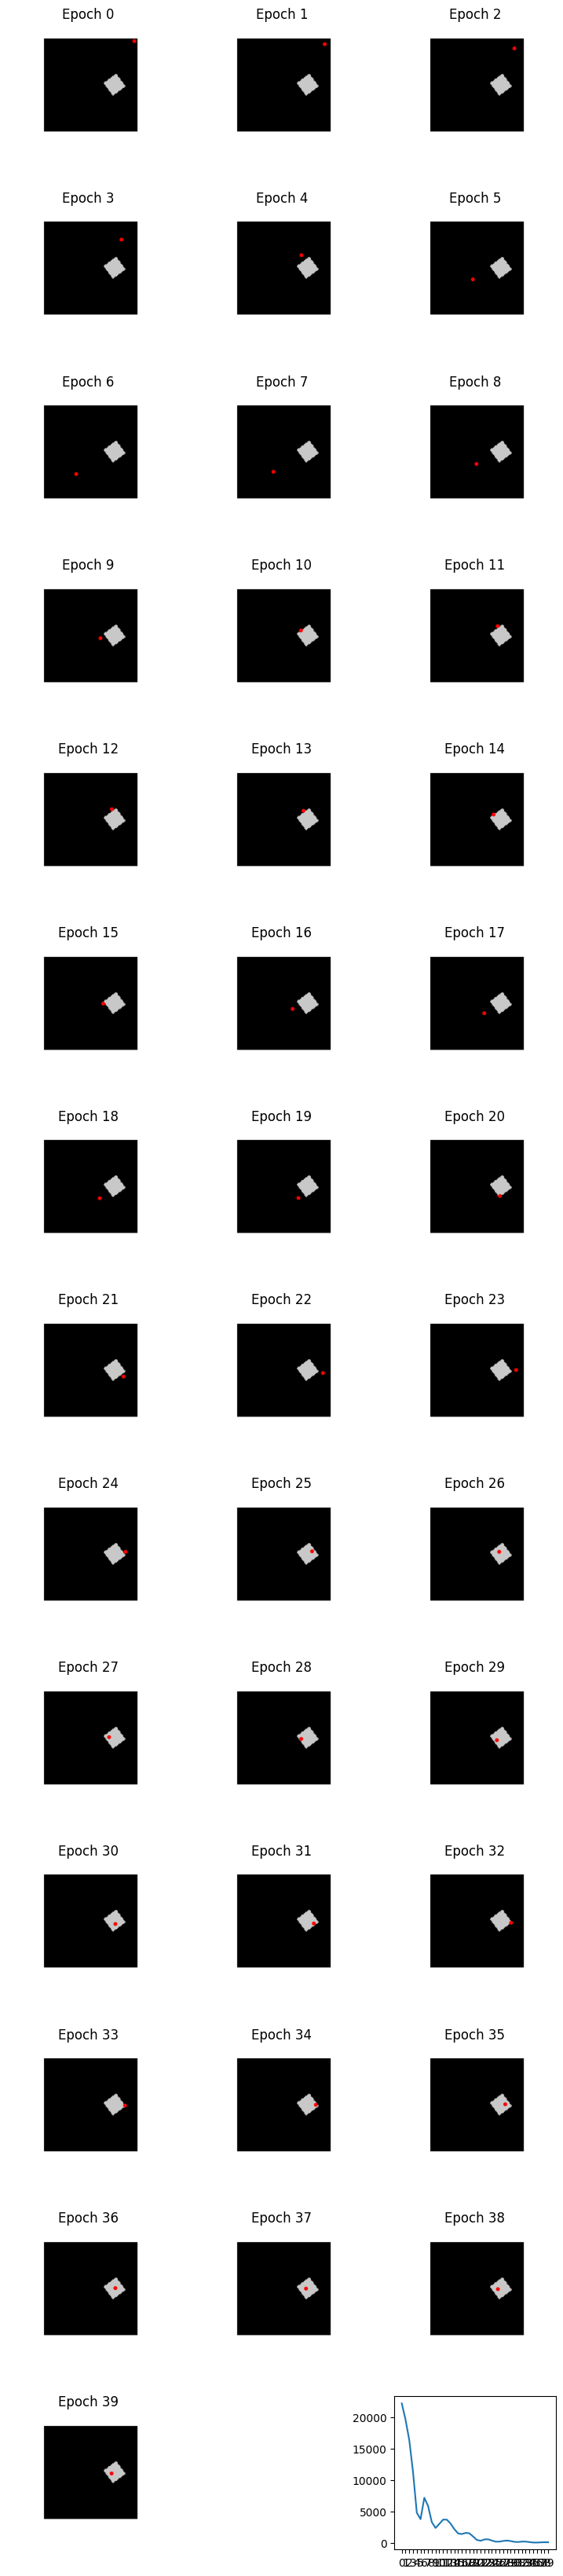

In [7]:
# go through all images and plot them in a img grid
n_images = len(test_images) + 1
n_cols = 3
n_rows = n_images // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
for i in range(n_images - 1):
    this_ax = ax[i // n_cols, i % n_cols]
    this_ax.imshow(test_images[i], origin="lower")
    this_ax.axis("off")
    this_ax.set_title(f"Epoch {i}")

[a.axis("off") for a in ax.flatten()]

ax.flatten()[-1].plot(losses)
ax.flatten()[-1].axis("on")
ax.flatten()[-1].set_xticks(range(len(losses)))

plt.show();